In [1]:
import time
import os
import pickle
import pandas as pd
pd.set_option('display.max_colwidth', 1000)
import numpy as np
import json
import pandas_profiling
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics.scorer import make_scorer

axis_font = {'fontname':'Arial', 'size':'20'}
ticks_font = {'fontname':'Arial', 'size':'16'}
title_font = {'fontname': 'Arial', 'size': '24'}
import warnings
warnings.filterwarnings('ignore')

### Reading in Data

In [2]:
df1011 = pd.read_pickle('composite/final1011.pkl')
df1112 = pd.read_pickle('composite/final1112.pkl')
df1213 = pd.read_pickle('composite/final1213.pkl')
df1314 = pd.read_pickle('composite/final1314.pkl')
df1415 = pd.read_pickle('composite/final1415.pkl')
df1516 = pd.read_pickle('composite/final1516.pkl')
df1617 = pd.read_pickle('composite/final1617.pkl')
df1718 = pd.read_pickle('composite/final1718.pkl')

## Transforming Data (functions)

In [3]:
def getMicroROC(X_train, y_train, X_test, y_test):
    weights = [1.4 if x == 'Draw' else 1 for x in y_train]
    rforest = RandomForestClassifier(50,max_depth =500, min_samples_leaf= 75, max_features = 0.3,
                                     min_samples_split = 200, random_state = 54)
    rforest.fit(X_train, y_train, sample_weight=weights)
    pred = rforest.predict(X_test)
    y_score=rforest.predict_proba(X_test)
    n_classes = y_score.shape[1]
    y_one_hot = label_binarize(y_test, classes = ['Away Win','Draw', 'Home Win'])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    # # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_one_hot.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return fpr, tpr, roc_auc

In [4]:
def getPreviewStats(season):
    #TRIM TO DATASET CONTAINING PREVIEW FEATURES
    preview = season[['date','homeTeam', 'awayTeam', 'homePredAvgAge', 'awayPredAvgAge',
                     'homePredAvgHeight', 'awayPredAvgHeight', 'homeWins',
                     'homeDraws', 'homeLosses', 'awayWins', 'awayDraws', 'awayLosses',
                     'homeTopPlayerMissing', 'homeTopPlayerDoubtful', 'awayTopPlayerMissing',
                     'awayTopPlayerDoubtful', 'outcome', 'awayOdds', 'drawOdds', 'homeOdds']]
    return preview

In [5]:
def getPastStats(season):
    #DATASET CONTAINING PAST FEATURES - THIS WILL BE AVERAGED by using the getPastAverages function
    past = season.drop(['date', 'homePredAvgAge', 'awayPredAvgAge',
                       'homePredAvgHeight', 'awayPredAvgHeight', 'homeWins', 
                       'homeDraws', 'homeLosses', 'awayWins', 'awayDraws', 'awayLosses',
                       'awayFormation', 'awayManager', 'awayTopPlayers', 'homeFormation',
                       'homeManager', 'homeTopPlayers', 'referee', 'url', 'awayOdds', 'drawOdds',
                       'homeOdds', 'outcome', 'homeTimeline', 'awayTimeline', 'homeTopPlayerMissing',
                       'homeTopPlayerDoubtful', 'awayTopPlayerMissing', 'awayTopPlayerDoubtful',
                       'missingPlayers', 'doubtfulPlayers'], axis = 1)

    return past

In [6]:
def rollingAverages(season, window_decay, avgtype = 'rolling', features = 'both'):
    if avgtype == 'rolling':
        homepaststats = season.groupby('homeTeam', as_index = False).rolling(window_decay, min_periods = 1).mean().reset_index(level = 0, drop = True)
        awaypaststats = season.groupby('awayTeam', as_index = False).rolling(window_decay, min_periods = 1).mean().reset_index(level = 0, drop = True)
    elif avgtype == 'ewm':
        homepaststats = season.groupby('homeTeam', as_index = False).apply(lambda x: x.ewm(halflife = window_decay).mean()).reset_index(level = 0, drop = True)
        awaypaststats = season.groupby('awayTeam', as_index = False).apply(lambda x: x.ewm(halflife = window_decay).mean()).reset_index(level = 0, drop = True)
    elif avgtype == 'expanding':
        homepaststats = season.groupby('homeTeam', as_index = False).expanding(min_periods = 1).mean().reset_index(level = 0, drop = True)
        awaypaststats = season.groupby('awayTeam', as_index = False).expanding(min_periods = 1).mean().reset_index(level = 0, drop = True)
    else:
        print("Please enter either 'rolling', 'ewm', or 'expanding'")
    
    #select all columns that are not home and away team
    shiftcolumns = homepaststats.drop(['homeTeam', 'awayTeam'], axis = 1).columns.values
    #shift all selected columns down by one
    homepaststats[shiftcolumns] = homepaststats.groupby(['homeTeam'])[shiftcolumns].transform(lambda x:x.shift())
    
    #select all columns that are not home and away team
    shiftcolumns = awaypaststats.drop(['homeTeam', 'awayTeam'], axis = 1).columns.values 
    #shift all selected columns down by one
    awaypaststats[shiftcolumns] = awaypaststats.groupby(['awayTeam'])[shiftcolumns].transform(lambda x:x.shift())

    diff = (homepaststats.drop(['homeTeam', 'awayTeam'], axis = 1) - awaypaststats.drop(['homeTeam', 'awayTeam'], axis = 1))
    diff['homeTeam'] = homepaststats.homeTeam
    diff['awayTeam'] = homepaststats.awayTeam
    
    both = pd.merge(homepaststats, awaypaststats,  how='outer', left_on=['homeTeam','awayTeam'], right_on = ['homeTeam','awayTeam'], suffixes=('_home', '_away'))
    
    if features == 'both':
        return both
    elif features == 'diff':
        return diff
    else:
        print("Please enter either 'both' or 'diff'")

In [7]:
def profitGraph(profitTable):
    bankroll = 0
    bankrollbydate = []
    baseline = 0
    baselinebydate = []
    dates = []
    profitbydate = profitTable.groupby('date', as_index=False)[['profit', 'baselineProfit']].sum()
    for i in range(len(profitbydate)):
        bankroll = bankroll + profitbydate.iloc[i,1]
        dates.append(profitbydate.iloc[i,0])
        bankrollbydate.append(bankroll)
        baseline = baseline + profitbydate.iloc[i,2]
        baselinebydate.append(baseline)

    plt.figure(figsize=(15,6));
    plt.plot(range(len(dates)),bankrollbydate,  label = 'prediction')
    plt.plot(range(len(dates)),baselinebydate, label = 'baseline')
    plt.xlabel('Days Where Bets are Placed (Time)', **axis_font)
    plt.ylabel('Profit', **axis_font)
    plt.title('Profit over Time', **title_font)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize = 'medium', fancybox = True)
    plt.show();

Want to work on formation/manager/referee

# Classification imports and functions

1. Create dataframe with one row with ALL features
2. Keep game weeks 31-38 per season as test set
3. Use k-folds cross val on the 70% of data (dont worry about messing with the dates?)
4. Predict game 31 using data from 1-30. Partial fit to include game 31.
5. Predict games 32-38 using similar steps as above
6. Look into categorical variables/Cross- season modeling

In [8]:
from sklearn.preprocessing import scale, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [9]:
def profit(unit, odds):
    profit = 0
    if odds > 0:
        profit = odds*(unit/100)
    else:
        profit = -(100/odds) * unit
    return profit

In [10]:
def totalProfit(oddsTable, unit, pred): #add second argument of predictions
    outcomes = oddsTable[:]
    outcomes['prediction'] = pred
    outcomes['baseline'] = 'Home Win'
    outcomes['outcomeOdds'] = np.where(outcomes['outcome'] == 'Home Win',
                                        outcomes.homeOdds,
                                        np.where(outcomes['outcome'] == 'Away Win',
                                                 outcomes.awayOdds,
                                                 outcomes.drawOdds))
    outcomes['outcomeOdds'] = pd.to_numeric(outcomes.outcomeOdds)
    outcomes.outcomeOdds.apply(lambda x: profit(unit, x))
    outcomes['profit'] = outcomes.apply(lambda row:
                                          profit(unit, row['outcomeOdds']) if row['outcome'] == row['prediction']
                                          else 0 if row['prediction'] == 'None' else -unit, axis = 1)
    outcomes['baselineProfit'] = outcomes.apply(lambda row:
                                          profit(unit, row['outcomeOdds']) if row['outcome'] == row['baseline']
                                          else 0 if row['prediction'] == 'None' else -unit, axis = 1)
    return outcomes


In [11]:
def createXandY(season):
    X = season.drop(['homeTeam', 'awayTeam', 'date', 'outcome'], axis = 1).reset_index(drop=True)
    y = season.outcome.reset_index(drop=True)
    trainSize = 0.7
    split = round(len(X)*trainSize)
    X_train, y_train, X_test, y_test = X.iloc[:split, :], y[:split], X.iloc[split:, :], y[split:]
    return X_train, y_train, X_test, y_test

In [12]:
def getScores(season, X_train, y_train, X_test, y_test, unit = 15):
    weights = [1 if x == 'Home Win' else 1.2 for x in y_train]
    sX_train = scale(X_train)
    sX_test = scale(X_test)
    log = LogisticRegression(penalty = 'l1', C = 0.1)
    log.fit(sX_train, y_train, sample_weight = weights)
    logpred = log.predict(sX_test)
    print("Logistic Accuracy Score: %0.2f" % (accuracy_score(y_test, logpred)))
    print("Logistic Train Score: %0.2f" % (log.score(sX_train, y_train)))
    print("Profit betting 15$: %0.2f" % (totalProfit(season, unit,logpred)).profit.sum())

    rforest2 = RandomForestClassifier(50,max_depth =100, min_samples_leaf= 5, max_features = 0.3,min_samples_split = 75)
    rforest2.fit(X_train, y_train, sample_weight=weights)
    forestpred = rforest2.predict(X_test)
    print("\nRandom Forest Accuracy Score: %0.2f" % (accuracy_score(y_test, forestpred)))
    print("Random Forest Train Score: %0.2f" % (rforest2.score(X_train, y_train)))
    print("Profit betting 15$: %0.2f" % (totalProfit(season,unit,forestpred)).profit.sum())
    print("%s" % (totalProfit(season,unit,forestpred)).prediction.value_counts())
    return forestpred, logpred

# One Model Per Season

In [13]:
## ASSUMING UNIT OF 15 FOR NOW
unit = 15

## 2010-2011

### Rolling Averages - Using two sets of features for both teams

In [14]:
preview1011 = getPreviewStats(df1011)
past1011 = rollingAverages(getPastStats(df1011), 5, 'rolling', 'both')
total1011 = pd.merge(preview1011, past1011, how='left', left_on=['homeTeam','awayTeam'], right_on = ['homeTeam','awayTeam'])
total1011 = total1011.dropna()

In [15]:
X = total1011.drop(['homeTeam', 'awayTeam', 'date', 'outcome'], axis = 1).reset_index(drop=True)
X.awayOdds = pd.to_numeric(X.awayOdds)
X.drawOdds = pd.to_numeric(X.drawOdds)
X.homeOdds = pd.to_numeric(X.homeOdds)
y = total1011.outcome.reset_index(drop=True)

In [16]:
trainSize = 0.7
split = round(len(X)*trainSize)

In [17]:
X_train, y_train, X_test, y_test = X.iloc[:split, :], y[:split], X.iloc[split:, :], y[split:]
outcomeTable = total1011[['date','homeTeam', 'awayTeam', 'homeOdds', 'awayOdds',
                       'drawOdds', 'outcome']].iloc[split:, :]

In [18]:
forestpred, logpred = getScores(outcomeTable, X_train, y_train, X_test, y_test)

Logistic Accuracy Score: 0.47
Logistic Train Score: 0.61
Profit betting 15$: -115.82

Random Forest Accuracy Score: 0.48
Random Forest Train Score: 0.67
Profit betting 15$: -23.61
Home Win    84
Draw        22
Away Win     1
Name: prediction, dtype: int64


### BASELINE 

In [19]:
profitTable = totalProfit(outcomeTable, 15, forestpred)
print("Baseline %s: " % (profitTable.baselineProfit.sum()))
print("Prediction %s: " % (profitTable.profit.sum()))

Baseline 51.978014197729465: 
Prediction -23.6104473407321: 


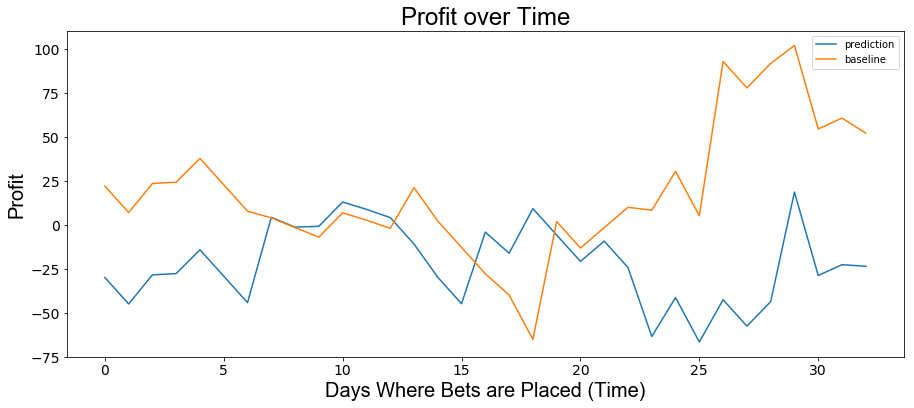

In [20]:
profitGraph(profitTable)

### Rolling Averages - Using difference of features for both teams

In [21]:
preview1011 = getPreviewStats(df1011)
past1011 = rollingAverages(getPastStats(df1011), 5, 'rolling', 'diff')
total1011 = pd.merge(preview1011, past1011, how='left', left_on=['homeTeam','awayTeam'], right_on = ['homeTeam','awayTeam'])
total1011 = total1011.dropna()

In [22]:
X = total1011.drop(['homeTeam', 'awayTeam', 'date', 'outcome'], axis = 1).reset_index(drop=True)
pd.to_numeric(X.awayOdds)
pd.to_numeric(X.drawOdds)
pd.to_numeric(X.homeOdds)
y = total1011.outcome.reset_index(drop=True)

In [23]:
trainSize = 0.7
split = round(len(X)*trainSize)

In [24]:
X_train, y_train, X_test, y_test = X.iloc[:split, :], y[:split], X.iloc[split:, :], y[split:]
outcomeTable = total1011[['date','homeTeam', 'awayTeam', 'homeOdds', 'awayOdds',
                       'drawOdds', 'outcome']].iloc[split:, :]

In [25]:
forestpred, logpred = getScores(outcomeTable, X_train, y_train, X_test, y_test)

Logistic Accuracy Score: 0.46
Logistic Train Score: 0.55
Profit betting 15$: -187.23

Random Forest Accuracy Score: 0.47
Random Forest Train Score: 0.66
Profit betting 15$: -183.95
Home Win    79
Away Win    15
Draw        13
Name: prediction, dtype: int64


### BASELINE 

In [26]:
profitTable = totalProfit(outcomeTable, 15, forestpred)
print("Baseline %s: " % (profitTable.baselineProfit.sum()))
print("Prediction %s: " % (profitTable.profit.sum()))

Baseline 51.978014197729465: 
Prediction -183.94843279895068: 


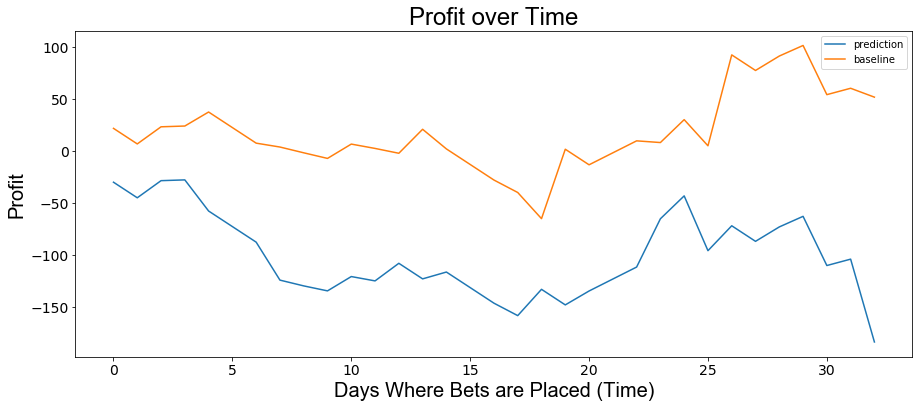

In [27]:
profitGraph(profitTable)

### Exponential Averages - Using two sets of features for both teams

In [28]:
preview1011 = getPreviewStats(df1011)
past1011 = rollingAverages(getPastStats(df1011), 5, 'ewm', 'both')
total1011 = pd.merge(preview1011, past1011, how='left', left_on=['homeTeam','awayTeam'], right_on = ['homeTeam','awayTeam'])
total1011 = total1011.dropna()

In [29]:
X = total1011.drop(['homeTeam', 'awayTeam', 'date', 'outcome'], axis = 1).reset_index(drop=True)
y = total1011.outcome.reset_index(drop=True)

In [30]:
trainSize = 0.7
split = round(len(X)*trainSize)

In [31]:
X_train, y_train, X_test, y_test = X.iloc[:split, :], y[:split], X.iloc[split:, :], y[split:]
outcomeTable = total1011[['date','homeTeam', 'awayTeam', 'homeOdds', 'awayOdds',
                       'drawOdds', 'outcome']].iloc[split:, :]

In [32]:
forestpred, logpred = getScores(outcomeTable, X_train, y_train, X_test, y_test)

Logistic Accuracy Score: 0.43
Logistic Train Score: 0.63
Profit betting 15$: -297.80

Random Forest Accuracy Score: 0.52
Random Forest Train Score: 0.65
Profit betting 15$: 124.48
Home Win    82
Draw        19
Away Win     6
Name: prediction, dtype: int64


### BASELINE 

In [33]:
profitTable = totalProfit(outcomeTable, 15, forestpred)
print("Baseline %s: " % (profitTable.baselineProfit.sum()))
print("Prediction %s: " % (profitTable.profit.sum()))

Baseline 51.978014197729465: 
Prediction 124.48285491005913: 


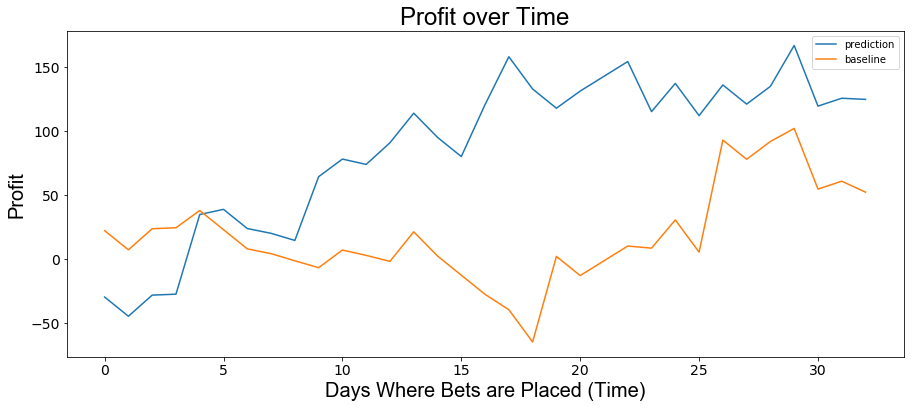

In [34]:
profitGraph(profitTable)

### Exponential Averages -  Using difference of features

In [35]:
preview1011 = getPreviewStats(df1011)
past1011 = rollingAverages(getPastStats(df1011), 5, 'ewm', 'diff')
total1011 = pd.merge(preview1011, past1011, how='left', left_on=['homeTeam','awayTeam'], right_on = ['homeTeam','awayTeam'])
total1011 = total1011.dropna()

In [36]:
X = total1011.drop(['homeTeam', 'awayTeam', 'date', 'outcome'], axis = 1).reset_index(drop=True)
y = total1011.outcome.reset_index(drop=True)

In [37]:
trainSize = 0.7
split = round(len(X)*trainSize)

In [38]:
X_train, y_train, X_test, y_test = X.iloc[:split, :], y[:split], X.iloc[split:, :], y[split:]
outcomeTable = total1011[['date','homeTeam', 'awayTeam', 'homeOdds', 'awayOdds',
                       'drawOdds', 'outcome']].iloc[split:, :]

In [39]:
forestpred, logpred = getScores(outcomeTable, X_train, y_train, X_test, y_test)

Logistic Accuracy Score: 0.49
Logistic Train Score: 0.56
Profit betting 15$: -139.39

Random Forest Accuracy Score: 0.50
Random Forest Train Score: 0.66
Profit betting 15$: -57.03
Home Win    84
Away Win    12
Draw        11
Name: prediction, dtype: int64


### BASELINE 

In [40]:
profitTable = totalProfit(outcomeTable, 15, forestpred)
print("Baseline %s: " % (profitTable.baselineProfit.sum()))
print("Prediction %s: " % (profitTable.profit.sum()))

Baseline 51.978014197729465: 
Prediction -57.02884721760041: 


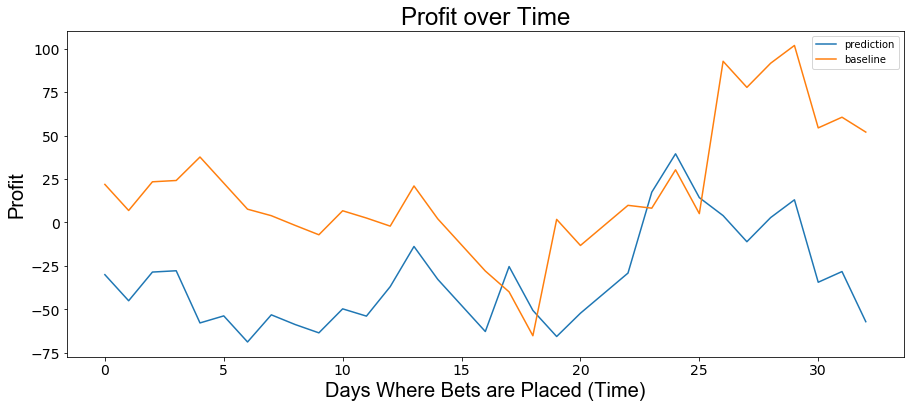

In [41]:
profitGraph(profitTable)

### Expanding Averages -  Using two sets of features for both teams

In [42]:
preview1011 = getPreviewStats(df1011)
past1011 = rollingAverages(getPastStats(df1011), 5, 'expanding', 'both')
total1011 = pd.merge(preview1011, past1011, how='left', left_on=['homeTeam','awayTeam'], right_on = ['homeTeam','awayTeam'])
total1011 = total1011.dropna()

In [43]:
X = total1011.drop(['homeTeam', 'awayTeam', 'date', 'outcome'], axis = 1).reset_index(drop=True)
y = total1011.outcome.reset_index(drop=True)

In [44]:
trainSize = 0.7
split = round(len(X)*trainSize)

In [45]:
X_train, y_train, X_test, y_test = X.iloc[:split, :], y[:split], X.iloc[split:, :], y[split:]
outcomeTable = total1011[['date','homeTeam', 'awayTeam', 'homeOdds', 'awayOdds',
                       'drawOdds', 'outcome']].iloc[split:, :]

In [46]:
forestpred, logpred = getScores(outcomeTable, X_train, y_train, X_test, y_test)

Logistic Accuracy Score: 0.48
Logistic Train Score: 0.61
Profit betting 15$: -78.72

Random Forest Accuracy Score: 0.51
Random Forest Train Score: 0.64
Profit betting 15$: 46.29
Home Win    89
Away Win    11
Draw         7
Name: prediction, dtype: int64


### BASELINE 

In [47]:
profitTable = totalProfit(outcomeTable, 15, forestpred)
print("Baseline %s: " % (profitTable.baselineProfit.sum()))
print("Prediction %s: " % (profitTable.profit.sum()))

Baseline 51.978014197729465: 
Prediction 46.289997767202: 


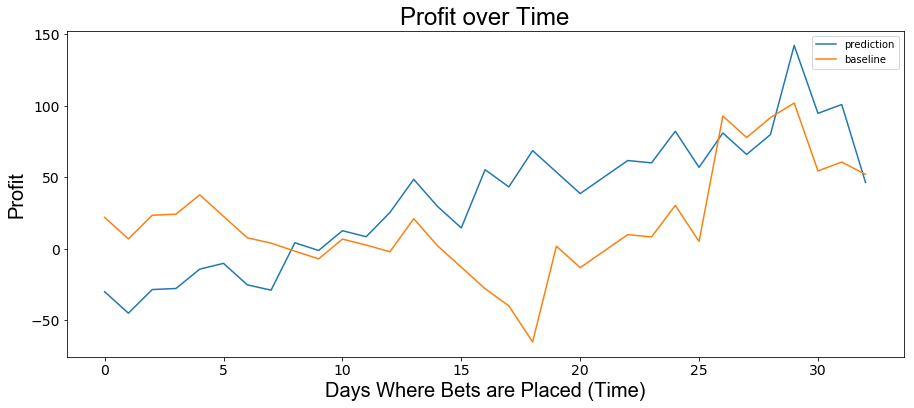

In [48]:
profitGraph(profitTable)

### Expanding Averages - Using difference of features

In [49]:
preview1011 = getPreviewStats(df1011)
past1011 = rollingAverages(getPastStats(df1011), 5, 'expanding', 'diff')
total1011 = pd.merge(preview1011, past1011, how='left', left_on=['homeTeam','awayTeam'], right_on = ['homeTeam','awayTeam'])
total1011 = total1011.dropna()

In [50]:
X = total1011.drop(['homeTeam', 'awayTeam', 'date', 'outcome'], axis = 1).reset_index(drop=True)
y = total1011.outcome.reset_index(drop=True)

In [51]:
trainSize = 0.7
split = round(len(X)*trainSize)

In [52]:
X_train, y_train, X_test, y_test = X.iloc[:split, :], y[:split], X.iloc[split:, :], y[split:]
outcomeTable = total1011[['date','homeTeam', 'awayTeam', 'homeOdds', 'awayOdds',
                       'drawOdds', 'outcome']].iloc[split:, :]

In [53]:
forestpred, logpred = getScores(outcomeTable, X_train, y_train, X_test, y_test)

Logistic Accuracy Score: 0.48
Logistic Train Score: 0.55
Profit betting 15$: -172.84

Random Forest Accuracy Score: 0.53
Random Forest Train Score: 0.67
Profit betting 15$: 81.56
Home Win    83
Away Win    17
Draw         7
Name: prediction, dtype: int64


### BASELINE 

In [54]:
profitTable = totalProfit(outcomeTable, 15, forestpred)
print("Baseline %s: " % (profitTable.baselineProfit.sum()))
print("Prediction %s: " % (profitTable.profit.sum()))

Baseline 51.978014197729465: 
Prediction 81.56066327191007: 


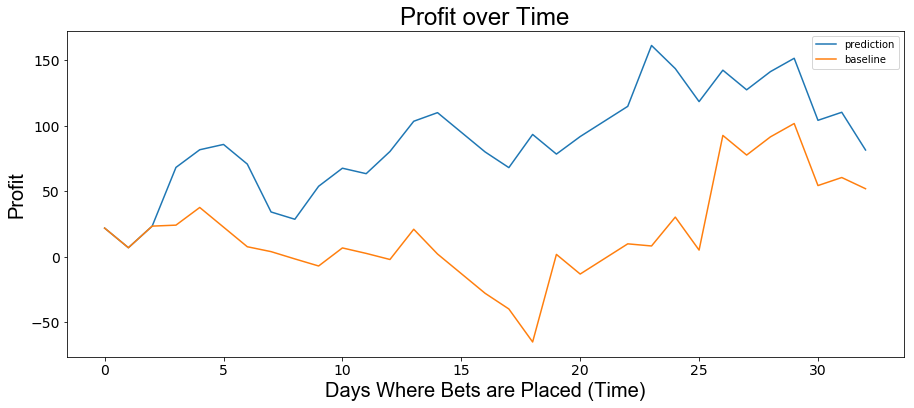

In [55]:
profitGraph(profitTable)

## 2011-2012

### Rolling Averages - Using two sets of features for both teams

In [56]:
preview = getPreviewStats(df1112)
past = rollingAverages(getPastStats(df1112), 5, 'rolling', 'both')
total = pd.merge(preview, past, how='left', left_on=['homeTeam','awayTeam'], right_on = ['homeTeam','awayTeam'])
total = total.dropna()

In [57]:
X = total.drop(['homeTeam', 'awayTeam', 'date', 'outcome'], axis = 1).reset_index(drop=True)
X.awayOdds = pd.to_numeric(X.awayOdds)
X.drawOdds = pd.to_numeric(X.drawOdds)
X.homeOdds = pd.to_numeric(X.homeOdds)
y = total.outcome.reset_index(drop=True)

In [58]:
trainSize = 0.7
split = round(len(X)*trainSize)

In [59]:
X_train, y_train, X_test, y_test = X.iloc[:split, :], y[:split], X.iloc[split:, :], y[split:]
outcomeTable = total[['date','homeTeam', 'awayTeam', 'homeOdds', 'awayOdds',
                       'drawOdds', 'outcome']].iloc[split:, :]

In [60]:
forestpred, logpred = getScores(outcomeTable, X_train, y_train, X_test, y_test)

Logistic Accuracy Score: 0.49
Logistic Train Score: 0.67
Profit betting 15$: -91.63

Random Forest Accuracy Score: 0.49
Random Forest Train Score: 0.63
Profit betting 15$: -85.08
Home Win    60
Away Win    46
Draw         2
Name: prediction, dtype: int64


### BASELINE 

In [61]:
profitTable = totalProfit(outcomeTable, 15, forestpred)
print("Baseline %s: " % (profitTable.baselineProfit.sum()))
print("Prediction %s: " % (profitTable.profit.sum()))

Baseline 156.37509884129975: 
Prediction -85.07836099489629: 


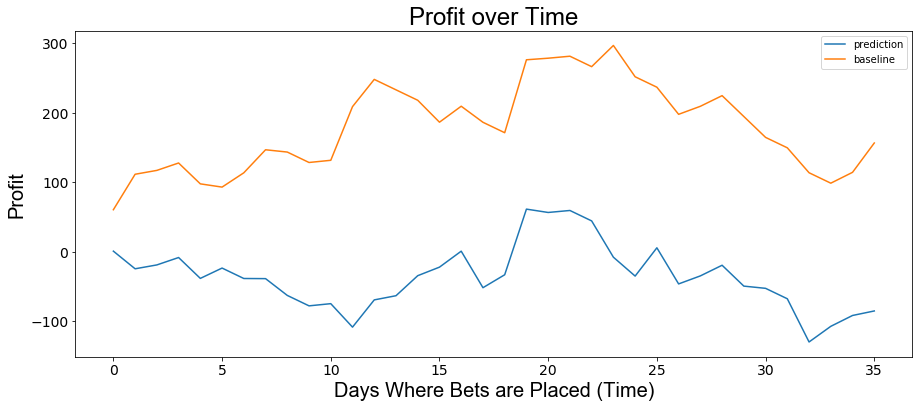

In [62]:
profitGraph(profitTable)

### Rolling Averages - Using difference of features for both teams

In [63]:
preview = getPreviewStats(df1112)
past = rollingAverages(getPastStats(df1112), 5, 'rolling', 'diff')
total = pd.merge(preview, past, how='left', left_on=['homeTeam','awayTeam'], right_on = ['homeTeam','awayTeam'])
total = total.dropna()

In [64]:
X = total.drop(['homeTeam', 'awayTeam', 'date', 'outcome'], axis = 1).reset_index(drop=True)
pd.to_numeric(X.awayOdds)
pd.to_numeric(X.drawOdds)
pd.to_numeric(X.homeOdds)
y = total.outcome.reset_index(drop=True)

In [65]:
trainSize = 0.7
split = round(len(X)*trainSize)

In [66]:
X_train, y_train, X_test, y_test = X.iloc[:split, :], y[:split], X.iloc[split:, :], y[split:]
outcomeTable = total[['date','homeTeam', 'awayTeam', 'homeOdds', 'awayOdds',
                       'drawOdds', 'outcome']].iloc[split:, :]

In [67]:
forestpred, logpred = getScores(outcomeTable, X_train, y_train, X_test, y_test)

Logistic Accuracy Score: 0.54
Logistic Train Score: 0.62
Profit betting 15$: 36.04

Random Forest Accuracy Score: 0.47
Random Forest Train Score: 0.63
Profit betting 15$: -173.29
Away Win    55
Home Win    53
Name: prediction, dtype: int64


### BASELINE 

In [68]:
profitTable = totalProfit(outcomeTable, 15, forestpred)
print("Baseline %s: " % (profitTable.baselineProfit.sum()))
print("Prediction %s: " % (profitTable.profit.sum()))

Baseline 156.37509884129975: 
Prediction -173.2949541658938: 


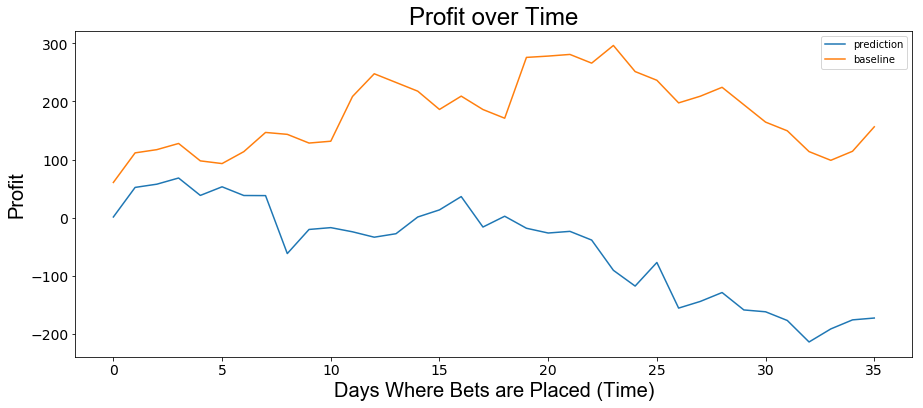

In [69]:
profitGraph(profitTable)

### Exponential Averages - Using two sets of features for both teams

In [70]:
preview = getPreviewStats(df1112)
past = rollingAverages(getPastStats(df1112), 5, 'ewm', 'both')
total = pd.merge(preview, past, how='left', left_on=['homeTeam','awayTeam'], right_on = ['homeTeam','awayTeam'])
total = total.dropna()

In [71]:
X = total.drop(['homeTeam', 'awayTeam', 'date', 'outcome'], axis = 1).reset_index(drop=True)
y = total.outcome.reset_index(drop=True)

In [72]:
trainSize = 0.7
split = round(len(X)*trainSize)

In [73]:
X_train, y_train, X_test, y_test = X.iloc[:split, :], y[:split], X.iloc[split:, :], y[split:]
outcomeTable = total[['date','homeTeam', 'awayTeam', 'homeOdds', 'awayOdds',
                       'drawOdds', 'outcome']].iloc[split:, :]

In [74]:
forestpred, logpred = getScores(outcomeTable, X_train, y_train, X_test, y_test)

Logistic Accuracy Score: 0.48
Logistic Train Score: 0.66
Profit betting 15$: -157.89

Random Forest Accuracy Score: 0.51
Random Forest Train Score: 0.64
Profit betting 15$: -89.25
Home Win    55
Away Win    49
Draw         4
Name: prediction, dtype: int64


### BASELINE 

In [75]:
profitTable = totalProfit(outcomeTable, 15, forestpred)
print("Baseline %s: " % (profitTable.baselineProfit.sum()))
print("Prediction %s: " % (profitTable.profit.sum()))

Baseline 156.37509884129975: 
Prediction -89.254856721392: 


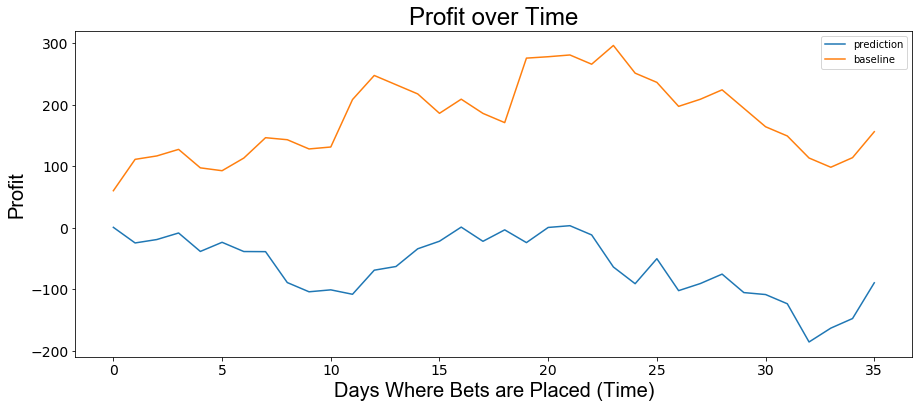

In [76]:
profitGraph(profitTable)

### Exponential Averages -  Using difference of features

In [77]:
preview = getPreviewStats(df1112)
past = rollingAverages(getPastStats(df1112), 5, 'ewm', 'diff')
total = pd.merge(preview, past, how='left', left_on=['homeTeam','awayTeam'], right_on = ['homeTeam','awayTeam'])
total = total.dropna()

In [78]:
X = total.drop(['homeTeam', 'awayTeam', 'date', 'outcome'], axis = 1).reset_index(drop=True)
y = total.outcome.reset_index(drop=True)

In [79]:
trainSize = 0.7
split = round(len(X)*trainSize)

In [80]:
X_train, y_train, X_test, y_test = X.iloc[:split, :], y[:split], X.iloc[split:, :], y[split:]
outcomeTable = total[['date','homeTeam', 'awayTeam', 'homeOdds', 'awayOdds',
                       'drawOdds', 'outcome']].iloc[split:, :]

In [81]:
forestpred, logpred = getScores(outcomeTable, X_train, y_train, X_test, y_test)

Logistic Accuracy Score: 0.51
Logistic Train Score: 0.62
Profit betting 15$: -70.44

Random Forest Accuracy Score: 0.53
Random Forest Train Score: 0.59
Profit betting 15$: -82.19
Home Win    59
Away Win    49
Name: prediction, dtype: int64


### BASELINE 

In [82]:
profitTable = totalProfit(outcomeTable, 15, forestpred)
print("Baseline %s: " % (profitTable.baselineProfit.sum()))
print("Prediction %s: " % (profitTable.profit.sum()))

Baseline 156.37509884129975: 
Prediction -82.18696813769108: 


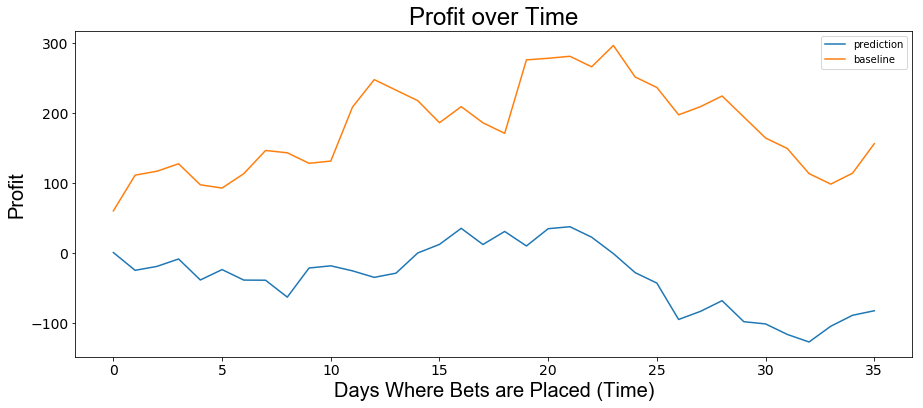

In [83]:
profitGraph(profitTable)

### Expanding Averages -  Using two sets of features for both teams

In [84]:
preview = getPreviewStats(df1112)
past = rollingAverages(getPastStats(df1112), 5, 'expanding', 'both')
total = pd.merge(preview, past, how='left', left_on=['homeTeam','awayTeam'], right_on = ['homeTeam','awayTeam'])
total = total.dropna()

In [85]:
X = total.drop(['homeTeam', 'awayTeam', 'date', 'outcome'], axis = 1).reset_index(drop=True)
y = total.outcome.reset_index(drop=True)

In [86]:
trainSize = 0.7
split = round(len(X)*trainSize)

In [87]:
X_train, y_train, X_test, y_test = X.iloc[:split, :], y[:split], X.iloc[split:, :], y[split:]
outcomeTable = total[['date','homeTeam', 'awayTeam', 'homeOdds', 'awayOdds',
                       'drawOdds', 'outcome']].iloc[split:, :]

In [88]:
forestpred, logpred = getScores(outcomeTable, X_train, y_train, X_test, y_test)

Logistic Accuracy Score: 0.51
Logistic Train Score: 0.67
Profit betting 15$: -26.41

Random Forest Accuracy Score: 0.47
Random Forest Train Score: 0.61
Profit betting 15$: -204.30
Away Win    58
Home Win    49
Draw         1
Name: prediction, dtype: int64


### BASELINE 

In [89]:
profitTable = totalProfit(outcomeTable, 15, forestpred)
print("Baseline %s: " % (profitTable.baselineProfit.sum()))
print("Prediction %s: " % (profitTable.profit.sum()))

Baseline 156.37509884129975: 
Prediction -204.29704042326608: 


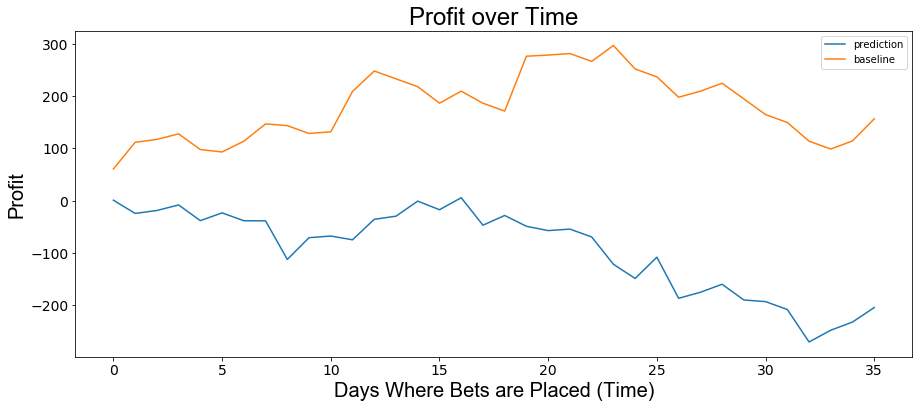

In [90]:
profitGraph(profitTable)

### Expanding Averages - Using difference of features

In [91]:
preview = getPreviewStats(df1112)
past = rollingAverages(getPastStats(df1112), 5, 'expanding', 'diff')
total = pd.merge(preview, past, how='left', left_on=['homeTeam','awayTeam'], right_on = ['homeTeam','awayTeam'])
total = total.dropna()

In [92]:
X = total.drop(['homeTeam', 'awayTeam', 'date', 'outcome'], axis = 1).reset_index(drop=True)
y = total.outcome.reset_index(drop=True)

In [93]:
trainSize = 0.7
split = round(len(X)*trainSize)

In [94]:
X_train, y_train, X_test, y_test = X.iloc[:split, :], y[:split], X.iloc[split:, :], y[split:]
outcomeTable = total[['date','homeTeam', 'awayTeam', 'homeOdds', 'awayOdds',
                       'drawOdds', 'outcome']].iloc[split:, :]

In [95]:
forestpred, logpred = getScores(outcomeTable, X_train, y_train, X_test, y_test)

Logistic Accuracy Score: 0.50
Logistic Train Score: 0.60
Profit betting 15$: -155.06

Random Forest Accuracy Score: 0.49
Random Forest Train Score: 0.61
Profit betting 15$: -161.39
Home Win    54
Away Win    54
Name: prediction, dtype: int64


### BASELINE 

In [96]:
profitTable = totalProfit(outcomeTable, 15, forestpred)
print("Baseline %s: " % (profitTable.baselineProfit.sum()))
print("Prediction %s: " % (profitTable.profit.sum()))

Baseline 156.37509884129975: 
Prediction -161.39026295067626: 


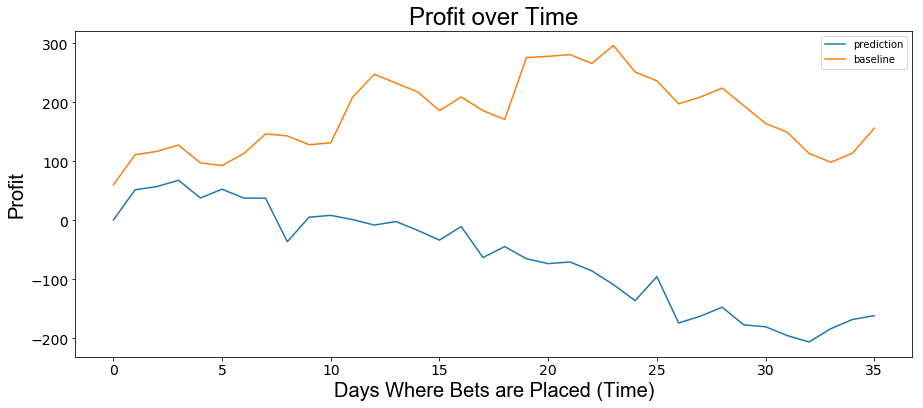

In [97]:
profitGraph(profitTable)

## 2015-2016

### Rolling Averages - Using two sets of features for both teams

In [98]:
preview = getPreviewStats(df1516)
past = rollingAverages(getPastStats(df1516), 5, 'rolling', 'both')
total = pd.merge(preview, past, how='left', left_on=['homeTeam','awayTeam'], right_on = ['homeTeam','awayTeam'])
total = total.dropna()

In [99]:
X = total.drop(['homeTeam', 'awayTeam', 'date', 'outcome'], axis = 1).reset_index(drop=True)
X.awayOdds = pd.to_numeric(X.awayOdds)
X.drawOdds = pd.to_numeric(X.drawOdds)
X.homeOdds = pd.to_numeric(X.homeOdds)
y = total.outcome.reset_index(drop=True)

In [100]:
trainSize = 0.7
split = round(len(X)*trainSize)

In [101]:
X_train, y_train, X_test, y_test = X.iloc[:split, :], y[:split], X.iloc[split:, :], y[split:]
outcomeTable = total[['date','homeTeam', 'awayTeam', 'homeOdds', 'awayOdds',
                       'drawOdds', 'outcome']].iloc[split:, :]

In [102]:
forestpred, logpred = getScores(outcomeTable, X_train, y_train, X_test, y_test)

Logistic Accuracy Score: 0.51
Logistic Train Score: 0.62
Profit betting 15$: 176.44

Random Forest Accuracy Score: 0.48
Random Forest Train Score: 0.71
Profit betting 15$: -132.04
Home Win    69
Away Win    33
Draw         6
Name: prediction, dtype: int64


### BASELINE 

In [103]:
profitTable = totalProfit(outcomeTable, 15, forestpred)
print("Baseline %s: " % (profitTable.baselineProfit.sum()))
print("Prediction %s: " % (profitTable.profit.sum()))

Baseline -98.83956568154869: 
Prediction -132.03815043013344: 


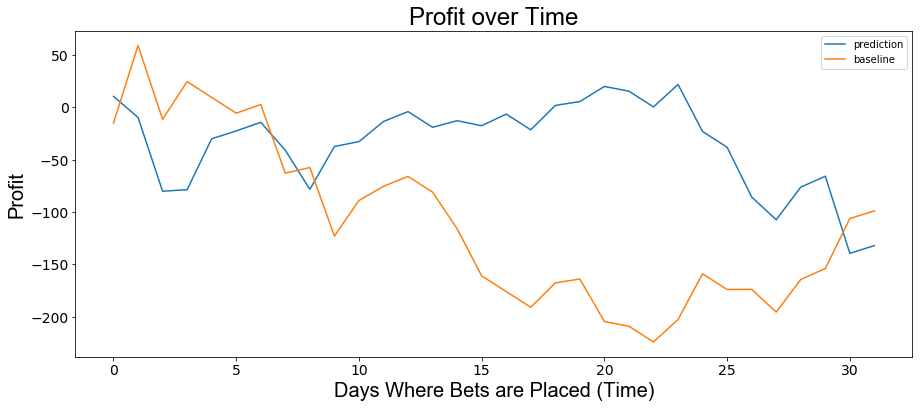

In [104]:
profitGraph(profitTable)

### Rolling Averages - Using difference of features for both teams

In [105]:
preview = getPreviewStats(df1516)
past = rollingAverages(getPastStats(df1516), 5, 'rolling', 'diff')
total = pd.merge(preview, past, how='left', left_on=['homeTeam','awayTeam'], right_on = ['homeTeam','awayTeam'])
total = total.dropna()

In [106]:
X = total.drop(['homeTeam', 'awayTeam', 'date', 'outcome'], axis = 1).reset_index(drop=True)
pd.to_numeric(X.awayOdds)
pd.to_numeric(X.drawOdds)
pd.to_numeric(X.homeOdds)
y = total.outcome.reset_index(drop=True)

In [107]:
trainSize = 0.7
split = round(len(X)*trainSize)

In [108]:
X_train, y_train, X_test, y_test = X.iloc[:split, :], y[:split], X.iloc[split:, :], y[split:]
outcomeTable = total[['date','homeTeam', 'awayTeam', 'homeOdds', 'awayOdds',
                       'drawOdds', 'outcome']].iloc[split:, :]

In [109]:
forestpred, logpred = getScores(outcomeTable, X_train, y_train, X_test, y_test)

Logistic Accuracy Score: 0.45
Logistic Train Score: 0.59
Profit betting 15$: -51.85

Random Forest Accuracy Score: 0.53
Random Forest Train Score: 0.65
Profit betting 15$: 123.43
Home Win    58
Away Win    36
Draw        14
Name: prediction, dtype: int64


### BASELINE 

In [110]:
profitTable = totalProfit(outcomeTable, 15, forestpred)
print("Baseline %s: " % (profitTable.baselineProfit.sum()))
print("Prediction %s: " % (profitTable.profit.sum()))

Baseline -98.83956568154869: 
Prediction 123.4253416333586: 


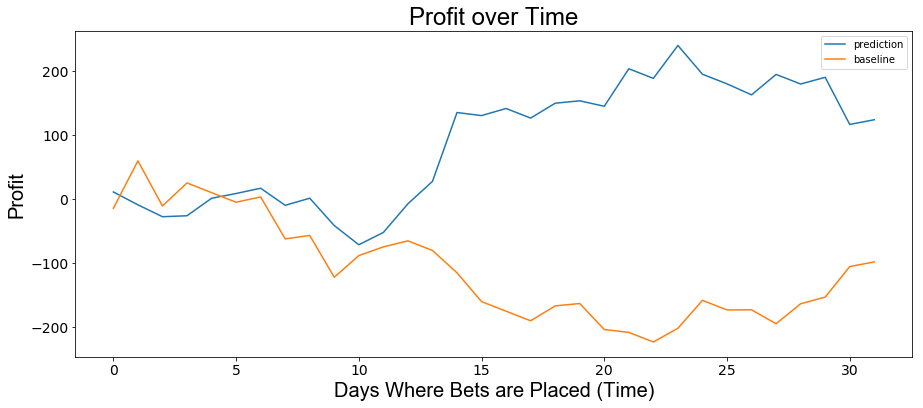

In [111]:
profitGraph(profitTable)

### Exponential Averages - Using two sets of features for both teams

In [112]:
preview = getPreviewStats(df1516)
past = rollingAverages(getPastStats(df1516), 5, 'ewm', 'both')
total = pd.merge(preview, past, how='left', left_on=['homeTeam','awayTeam'], right_on = ['homeTeam','awayTeam'])
total = total.dropna()

In [113]:
X = total.drop(['homeTeam', 'awayTeam', 'date', 'outcome'], axis = 1).reset_index(drop=True)
y = total.outcome.reset_index(drop=True)

In [114]:
trainSize = 0.7
split = round(len(X)*trainSize)

In [115]:
X_train, y_train, X_test, y_test = X.iloc[:split, :], y[:split], X.iloc[split:, :], y[split:]
outcomeTable = total[['date','homeTeam', 'awayTeam', 'homeOdds', 'awayOdds',
                       'drawOdds', 'outcome']].iloc[split:, :]

In [116]:
forestpred, logpred = getScores(outcomeTable, X_train, y_train, X_test, y_test)

Logistic Accuracy Score: 0.47
Logistic Train Score: 0.61
Profit betting 15$: -6.01

Random Forest Accuracy Score: 0.48
Random Forest Train Score: 0.67
Profit betting 15$: -142.08
Home Win    62
Away Win    43
Draw         3
Name: prediction, dtype: int64


### BASELINE 

In [117]:
profitTable = totalProfit(outcomeTable, 15, forestpred)
print("Baseline %s: " % (profitTable.baselineProfit.sum()))
print("Prediction %s: " % (profitTable.profit.sum()))

Baseline -98.83956568154869: 
Prediction -142.07766091964393: 


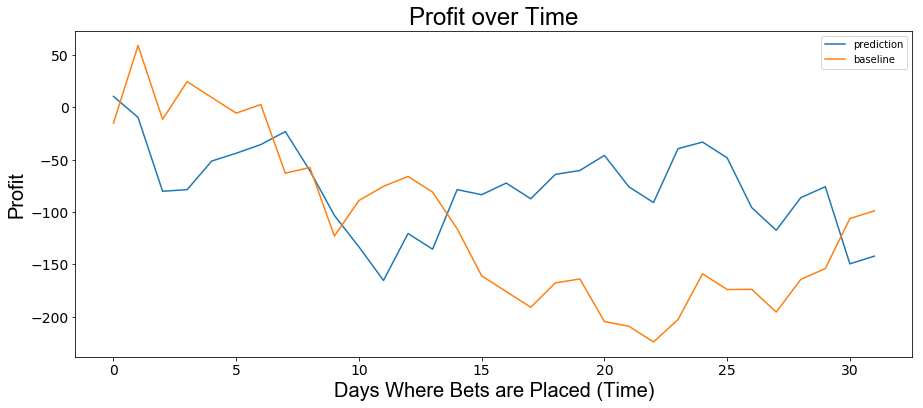

In [118]:
profitGraph(profitTable)

### Exponential Averages -  Using difference of features

In [119]:
preview = getPreviewStats(df1516)
past = rollingAverages(getPastStats(df1516), 5, 'ewm', 'diff')
total = pd.merge(preview, past, how='left', left_on=['homeTeam','awayTeam'], right_on = ['homeTeam','awayTeam'])
total = total.dropna()

In [120]:
X = total.drop(['homeTeam', 'awayTeam', 'date', 'outcome'], axis = 1).reset_index(drop=True)
y = total.outcome.reset_index(drop=True)

In [121]:
trainSize = 0.7
split = round(len(X)*trainSize)

In [122]:
X_train, y_train, X_test, y_test = X.iloc[:split, :], y[:split], X.iloc[split:, :], y[split:]
outcomeTable = total[['date','homeTeam', 'awayTeam', 'homeOdds', 'awayOdds',
                       'drawOdds', 'outcome']].iloc[split:, :]

In [123]:
forestpred, logpred = getScores(outcomeTable, X_train, y_train, X_test, y_test)

Logistic Accuracy Score: 0.48
Logistic Train Score: 0.57
Profit betting 15$: -24.90

Random Forest Accuracy Score: 0.46
Random Forest Train Score: 0.71
Profit betting 15$: -153.78
Home Win    71
Away Win    30
Draw         7
Name: prediction, dtype: int64


### BASELINE 

In [124]:
profitTable = totalProfit(outcomeTable, 15, forestpred)
print("Baseline %s: " % (profitTable.baselineProfit.sum()))
print("Prediction %s: " % (profitTable.profit.sum()))

Baseline -98.83956568154869: 
Prediction -153.7809390424873: 


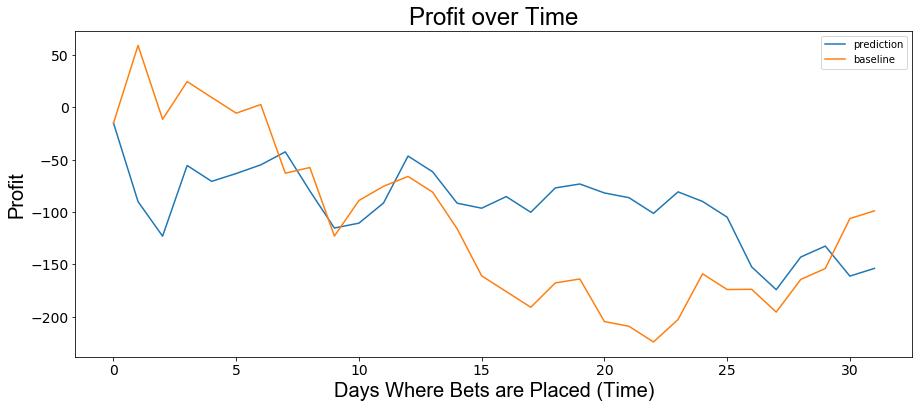

In [125]:
profitGraph(profitTable)

### Expanding Averages -  Using two sets of features for both teams

In [126]:
preview = getPreviewStats(df1516)
past = rollingAverages(getPastStats(df1516), 5, 'expanding', 'both')
total = pd.merge(preview, past, how='left', left_on=['homeTeam','awayTeam'], right_on = ['homeTeam','awayTeam'])
total = total.dropna()

In [127]:
X = total.drop(['homeTeam', 'awayTeam', 'date', 'outcome'], axis = 1).reset_index(drop=True)
y = total.outcome.reset_index(drop=True)

In [128]:
trainSize = 0.7
split = round(len(X)*trainSize)

In [129]:
X_train, y_train, X_test, y_test = X.iloc[:split, :], y[:split], X.iloc[split:, :], y[split:]
outcomeTable = total[['date','homeTeam', 'awayTeam', 'homeOdds', 'awayOdds',
                       'drawOdds', 'outcome']].iloc[split:, :]

In [130]:
forestpred, logpred = getScores(outcomeTable, X_train, y_train, X_test, y_test)

Logistic Accuracy Score: 0.48
Logistic Train Score: 0.61
Profit betting 15$: 10.16

Random Forest Accuracy Score: 0.52
Random Forest Train Score: 0.69
Profit betting 15$: 41.57
Home Win    60
Away Win    38
Draw        10
Name: prediction, dtype: int64


### BASELINE 

In [131]:
profitTable = totalProfit(outcomeTable, 15, forestpred)
print("Baseline %s: " % (profitTable.baselineProfit.sum()))
print("Prediction %s: " % (profitTable.profit.sum()))

Baseline -98.83956568154869: 
Prediction 41.56672761864707: 


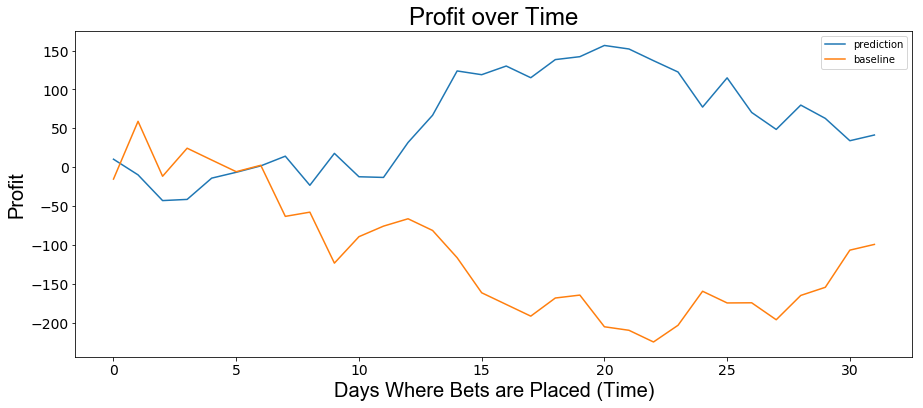

In [132]:
profitGraph(profitTable)

### Expanding Averages - Using difference of features

In [133]:
preview = getPreviewStats(df1516)
past = rollingAverages(getPastStats(df1516), 5, 'expanding', 'diff')
total = pd.merge(preview, past, how='left', left_on=['homeTeam','awayTeam'], right_on = ['homeTeam','awayTeam'])
total = total.dropna()

In [134]:
X = total.drop(['homeTeam', 'awayTeam', 'date', 'outcome'], axis = 1).reset_index(drop=True)
y = total.outcome.reset_index(drop=True)

In [135]:
trainSize = 0.7
split = round(len(X)*trainSize)

In [136]:
X_train, y_train, X_test, y_test = X.iloc[:split, :], y[:split], X.iloc[split:, :], y[split:]
outcomeTable = total[['date','homeTeam', 'awayTeam', 'homeOdds', 'awayOdds',
                       'drawOdds', 'outcome']].iloc[split:, :]

In [137]:
forestpred, logpred = getScores(outcomeTable, X_train, y_train, X_test, y_test)

Logistic Accuracy Score: 0.46
Logistic Train Score: 0.57
Profit betting 15$: -52.34

Random Forest Accuracy Score: 0.48
Random Forest Train Score: 0.65
Profit betting 15$: -159.32
Home Win    63
Away Win    39
Draw         6
Name: prediction, dtype: int64


### BASELINE 

In [138]:
profitTable = totalProfit(outcomeTable, 15, forestpred)
print("Baseline %s: " % (profitTable.baselineProfit.sum()))
print("Prediction %s: " % (profitTable.profit.sum()))

Baseline -98.83956568154869: 
Prediction -159.32465836664136: 


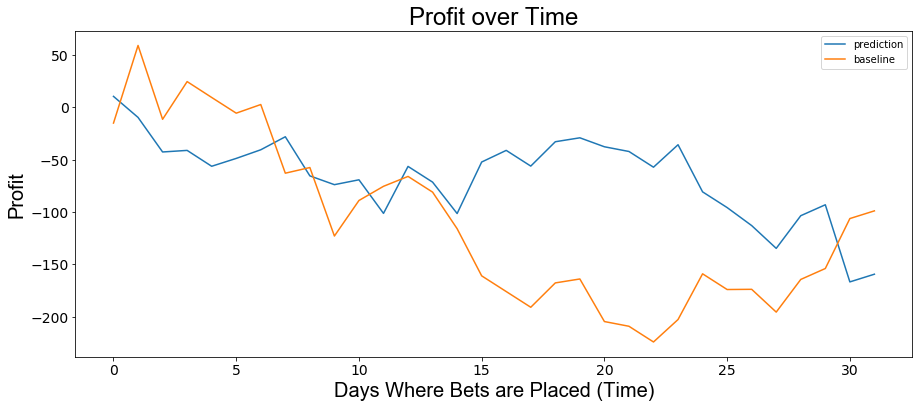

In [139]:
profitGraph(profitTable)

## 2016-2017

### Rolling Averages - Using two sets of features for both teams

In [140]:
preview = getPreviewStats(df1617)
past = rollingAverages(getPastStats(df1617), 5, 'rolling', 'both')
total = pd.merge(preview, past, how='left', left_on=['homeTeam','awayTeam'], right_on = ['homeTeam','awayTeam'])
total = total.dropna()

In [141]:
X = total.drop(['homeTeam', 'awayTeam', 'date', 'outcome'], axis = 1).reset_index(drop=True)
X.awayOdds = pd.to_numeric(X.awayOdds)
X.drawOdds = pd.to_numeric(X.drawOdds)
X.homeOdds = pd.to_numeric(X.homeOdds)
y = total.outcome.reset_index(drop=True)

In [142]:
trainSize = 0.7
split = round(len(X)*trainSize)

In [143]:
X_train, y_train, X_test, y_test = X.iloc[:split, :], y[:split], X.iloc[split:, :], y[split:]
outcomeTable = total[['date','homeTeam', 'awayTeam', 'homeOdds', 'awayOdds',
                       'drawOdds', 'outcome']].iloc[split:, :]

fpr_roll_both, tpr_roll_both, roc_auc_roll_both = getMicroROC(X_train, y_train, X_test, y_test)

In [144]:
forestpred, logpred = getScores(outcomeTable, X_train, y_train, X_test, y_test)

Logistic Accuracy Score: 0.67
Logistic Train Score: 0.65
Profit betting 15$: 304.26

Random Forest Accuracy Score: 0.65
Random Forest Train Score: 0.65
Profit betting 15$: 195.48
Home Win    81
Away Win    27
Name: prediction, dtype: int64


### BASELINE 

In [145]:
profitTable = totalProfit(outcomeTable, 15, forestpred)
print("Baseline %s: " % (profitTable.baselineProfit.sum()))
print("Prediction %s: " % (profitTable.profit.sum()))

Baseline -18.3351069834277: 
Prediction 195.47624369562018: 


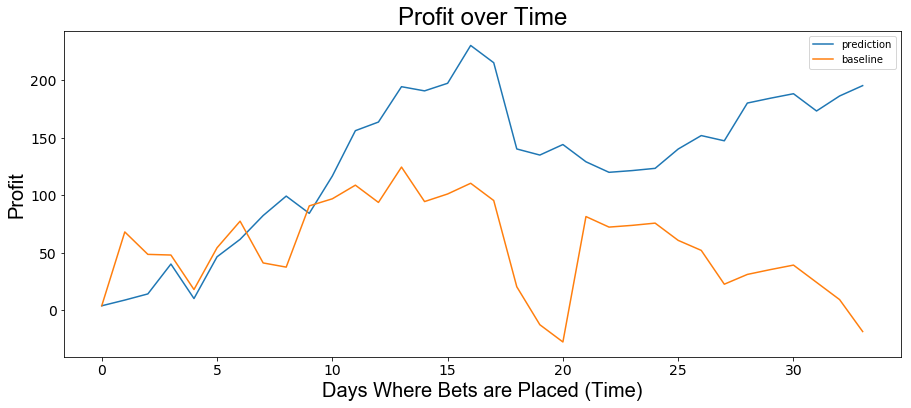

In [146]:
profitGraph(profitTable)

### Rolling Averages - Using difference of features for both teams

In [147]:
preview = getPreviewStats(df1617)
past = rollingAverages(getPastStats(df1617), 5, 'rolling', 'diff')
total = pd.merge(preview, past, how='left', left_on=['homeTeam','awayTeam'], right_on = ['homeTeam','awayTeam'])
total = total.dropna()

In [148]:
X = total.drop(['homeTeam', 'awayTeam', 'date', 'outcome'], axis = 1).reset_index(drop=True)
pd.to_numeric(X.awayOdds)
pd.to_numeric(X.drawOdds)
pd.to_numeric(X.homeOdds)
y = total.outcome.reset_index(drop=True)

In [149]:
trainSize = 0.7
split = round(len(X)*trainSize)

In [150]:
X_train, y_train, X_test, y_test = X.iloc[:split, :], y[:split], X.iloc[split:, :], y[split:]
outcomeTable = total[['date','homeTeam', 'awayTeam', 'homeOdds', 'awayOdds',
                       'drawOdds', 'outcome']].iloc[split:, :]

fpr_roll_diff, tpr_roll_diff, roc_auc_roll_diff = getMicroROC(X_train, y_train, X_test, y_test)

In [151]:
forestpred, logpred = getScores(outcomeTable, X_train, y_train, X_test, y_test)

Logistic Accuracy Score: 0.63
Logistic Train Score: 0.61
Profit betting 15$: 120.06

Random Forest Accuracy Score: 0.66
Random Forest Train Score: 0.63
Profit betting 15$: 239.88
Home Win    79
Away Win    26
Draw         3
Name: prediction, dtype: int64


### BASELINE 

In [152]:
profitTable = totalProfit(outcomeTable, 15, forestpred)
print("Baseline %s: " % (profitTable.baselineProfit.sum()))
print("Prediction %s: " % (profitTable.profit.sum()))

Baseline -18.3351069834277: 
Prediction 239.8762436956202: 


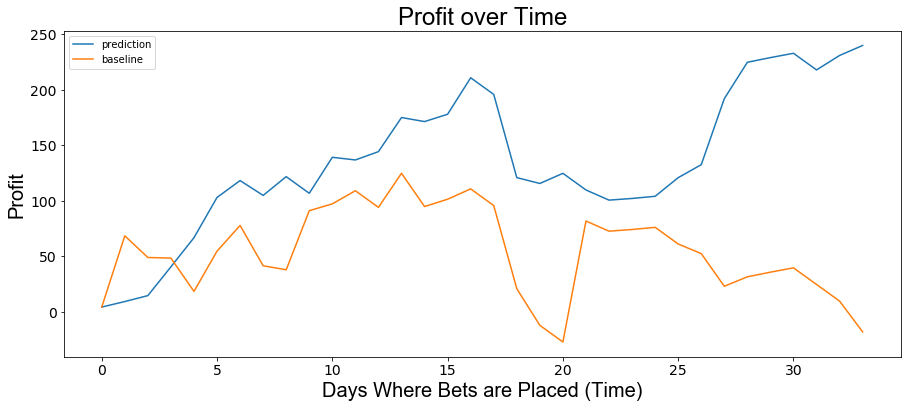

In [153]:
profitGraph(profitTable)

### Exponential Averages - Using two sets of features for both teams

In [154]:
preview = getPreviewStats(df1617)
past = rollingAverages(getPastStats(df1617), 5, 'ewm', 'both')
total = pd.merge(preview, past, how='left', left_on=['homeTeam','awayTeam'], right_on = ['homeTeam','awayTeam'])
total = total.dropna()

In [155]:
X = total.drop(['homeTeam', 'awayTeam', 'date', 'outcome'], axis = 1).reset_index(drop=True)
y = total.outcome.reset_index(drop=True)

In [156]:
trainSize = 0.7
split = round(len(X)*trainSize)

In [157]:
X_train, y_train, X_test, y_test = X.iloc[:split, :], y[:split], X.iloc[split:, :], y[split:]
outcomeTable = total[['date','homeTeam', 'awayTeam', 'homeOdds', 'awayOdds',
                       'drawOdds', 'outcome']].iloc[split:, :]

fpr_ewm_both, tpr_ewm_both, roc_auc_ewm_both = getMicroROC(X_train, y_train, X_test, y_test)

In [158]:
forestpred, logpred = getScores(outcomeTable, X_train, y_train, X_test, y_test)

Logistic Accuracy Score: 0.66
Logistic Train Score: 0.66
Profit betting 15$: 268.86

Random Forest Accuracy Score: 0.66
Random Forest Train Score: 0.65
Profit betting 15$: 227.73
Home Win    83
Away Win    25
Name: prediction, dtype: int64


### BASELINE 

In [159]:
profitTable = totalProfit(outcomeTable, 15, forestpred)
print("Baseline %s: " % (profitTable.baselineProfit.sum()))
print("Prediction %s: " % (profitTable.profit.sum()))

Baseline -18.3351069834277: 
Prediction 227.72624369562016: 


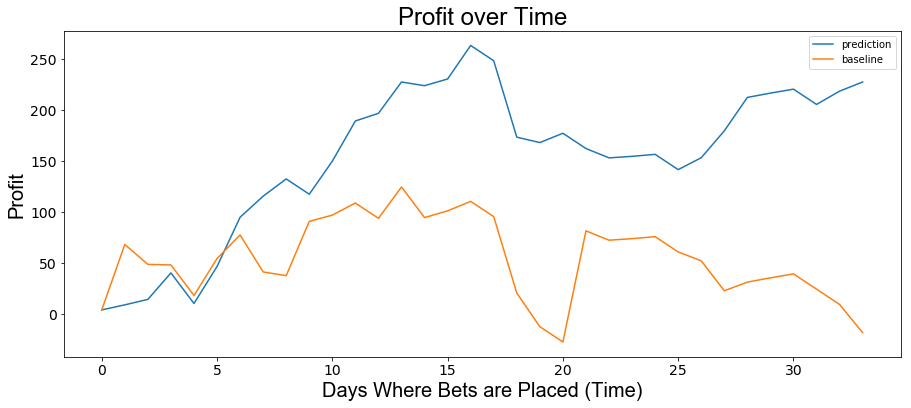

In [160]:
profitGraph(profitTable)

### Exponential Averages -  Using difference of features

In [161]:
preview = getPreviewStats(df1617)
past = rollingAverages(getPastStats(df1617), 5, 'ewm', 'diff')
total = pd.merge(preview, past, how='left', left_on=['homeTeam','awayTeam'], right_on = ['homeTeam','awayTeam'])
total = total.dropna()

In [162]:
X = total.drop(['homeTeam', 'awayTeam', 'date', 'outcome'], axis = 1).reset_index(drop=True)
y = total.outcome.reset_index(drop=True)

In [163]:
trainSize = 0.7
split = round(len(X)*trainSize)

In [164]:
X_train, y_train, X_test, y_test = X.iloc[:split, :], y[:split], X.iloc[split:, :], y[split:]
outcomeTable = total[['date','homeTeam', 'awayTeam', 'homeOdds', 'awayOdds',
                       'drawOdds', 'outcome']].iloc[split:, :]

fpr_ewm_diff, tpr_ewm_diff, roc_auc_ewm_diff = getMicroROC(X_train, y_train, X_test, y_test)

In [165]:
forestpred, logpred = getScores(outcomeTable, X_train, y_train, X_test, y_test)

Logistic Accuracy Score: 0.62
Logistic Train Score: 0.61
Profit betting 15$: 110.61

Random Forest Accuracy Score: 0.64
Random Forest Train Score: 0.65
Profit betting 15$: 144.18
Home Win    77
Away Win    28
Draw         3
Name: prediction, dtype: int64


### BASELINE 

In [166]:
profitTable = totalProfit(outcomeTable, 15, forestpred)
print("Baseline %s: " % (profitTable.baselineProfit.sum()))
print("Prediction %s: " % (profitTable.profit.sum()))

Baseline -18.3351069834277: 
Prediction 144.17624369562023: 


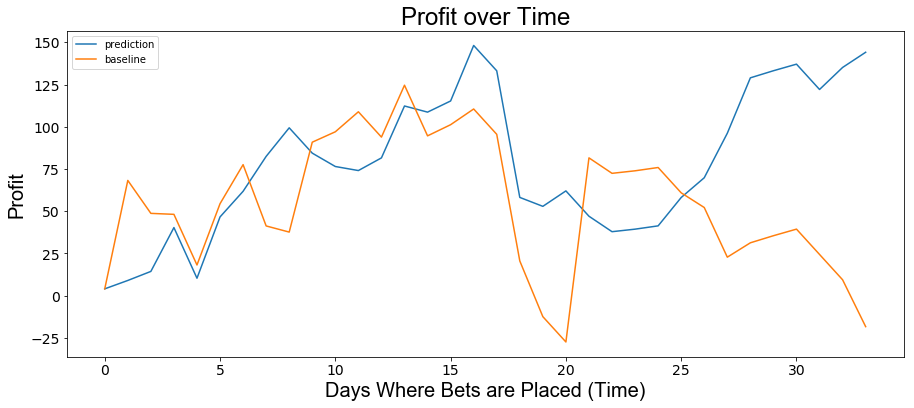

In [167]:
profitGraph(profitTable)

### Expanding Averages -  Using two sets of features for both teams

In [168]:
preview = getPreviewStats(df1617)
past = rollingAverages(getPastStats(df1617), 5, 'expanding', 'both')
total = pd.merge(preview, past, how='left', left_on=['homeTeam','awayTeam'], right_on = ['homeTeam','awayTeam'])
total = total.dropna()

In [169]:
X = total.drop(['homeTeam', 'awayTeam', 'date', 'outcome'], axis = 1).reset_index(drop=True)
y = total.outcome.reset_index(drop=True)

In [170]:
trainSize = 0.7
split = round(len(X)*trainSize)

In [171]:
X_train, y_train, X_test, y_test = X.iloc[:split, :], y[:split], X.iloc[split:, :], y[split:]
outcomeTable = total[['date','homeTeam', 'awayTeam', 'homeOdds', 'awayOdds',
                       'drawOdds', 'outcome']].iloc[split:, :]

fpr_expand_both, tpr_expand_both, roc_auc_expand_both = getMicroROC(X_train, y_train, X_test, y_test)

In [172]:
forestpred, logpred = getScores(outcomeTable, X_train, y_train, X_test, y_test)

Logistic Accuracy Score: 0.66
Logistic Train Score: 0.65
Profit betting 15$: 257.46

Random Forest Accuracy Score: 0.67
Random Forest Train Score: 0.64
Profit betting 15$: 259.53
Home Win    81
Away Win    27
Name: prediction, dtype: int64


### BASELINE 

In [173]:
profitTable = totalProfit(outcomeTable, 15, forestpred)
print("Baseline %s: " % (profitTable.baselineProfit.sum()))
print("Prediction %s: " % (profitTable.profit.sum()))

Baseline -18.3351069834277: 
Prediction 259.5262436956201: 


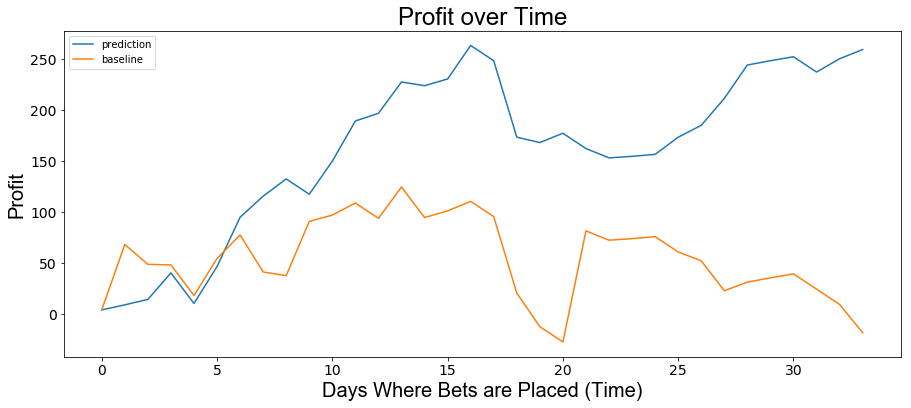

In [174]:
profitGraph(profitTable)

### Expanding Averages - Using difference of features

In [175]:
preview = getPreviewStats(df1617)
past = rollingAverages(getPastStats(df1617), 5, 'expanding', 'diff')
total = pd.merge(preview, past, how='left', left_on=['homeTeam','awayTeam'], right_on = ['homeTeam','awayTeam'])
total = total.dropna()

In [176]:
X = total.drop(['homeTeam', 'awayTeam', 'date', 'outcome'], axis = 1).reset_index(drop=True)
y = total.outcome.reset_index(drop=True)

In [177]:
trainSize = 0.7
split = round(len(X)*trainSize)

In [178]:
X_train, y_train, X_test, y_test = X.iloc[:split, :], y[:split], X.iloc[split:, :], y[split:]
outcomeTable = total[['date','homeTeam', 'awayTeam', 'homeOdds', 'awayOdds',
                       'drawOdds', 'outcome']].iloc[split:, :]

fpr_expand_diff, tpr_expand_diff, roc_auc_expand_diff = getMicroROC(X_train, y_train, X_test, y_test)

In [179]:
forestpred, logpred = getScores(outcomeTable, X_train, y_train, X_test, y_test)

Logistic Accuracy Score: 0.65
Logistic Train Score: 0.61
Profit betting 15$: 210.48

Random Forest Accuracy Score: 0.66
Random Forest Train Score: 0.62
Profit betting 15$: 231.48
Home Win    83
Away Win    25
Name: prediction, dtype: int64


### BASELINE 

In [180]:
profitTable = totalProfit(outcomeTable, 15, forestpred)
print("Baseline %s: " % (profitTable.baselineProfit.sum()))
print("Prediction %s: " % (profitTable.profit.sum()))

Baseline -18.3351069834277: 
Prediction 231.4827654347506: 


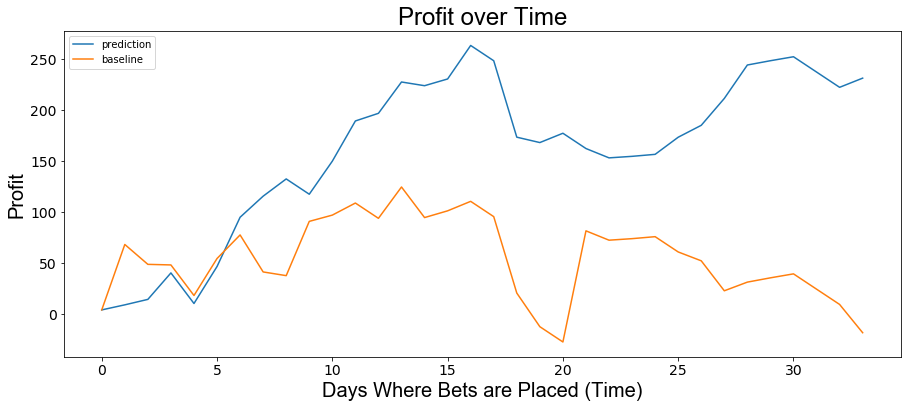

In [181]:
profitGraph(profitTable)

# ONE MODEL FOR ALL DATA

In [182]:
# !pip3 install kmeans-smote
# from imblearn.over_sampling import SMOTE

# smote = SMOTE(k_neighbors = 5,kind = "borderline1")
# X_smtrain, y_smtrain = smote.fit_sample(X_train, y_train)

In [183]:
def getScoresFull(season, X_train, y_train, X_test, y_test, unit = 15):
    weights = [1.4 if x == 'Draw' else 1 for x in y_train]
    sX_train = scale(X_train)
    sX_test = scale(X_test)
    log = LogisticRegression(penalty='l1', C = 0.1)
    log.fit(sX_train, y_train, sample_weight = weights)
    pred = log.predict(sX_test)
    print("Logistic Accuracy Score: %0.2f" % (accuracy_score(y_test, pred)))
    print("Logistic Train Score: %0.2f" % (log.score(sX_train, y_train)))
    print("Profit betting 15$: %0.2f" % (totalProfit(season,unit,pred)).profit.sum())

    rforest = RandomForestClassifier(50,max_depth =500, min_samples_leaf= 50, max_features = 0.3,
                                  min_samples_split = 150, random_state = 54) 
    rforest.fit(X_train, y_train, sample_weight=weights)
    pred = rforest.predict(X_test)
    print("\nRandom Forest Accuracy Score: %0.2f" % (accuracy_score(y_test, pred)))
    print("Random Forest Train Score: %0.2f" % (rforest.score(X_train, y_train)))
    print("Profit betting 15$: %0.2f" % (totalProfit(season,unit,pred)).profit.sum())

In [221]:
dflist = [df1011, df1112, df1213, df1314, df1415, df1516, df1617]

In [222]:
df1415[['homeTeam', 'awayTeam', 'homeTotalShots', 'awayPassTargetAtt']][df1415.homeTeam == 'Swansea']

,homeTeam,awayTeam,homeTotalShots,awayPassTargetAtt
14,Swansea,Burnley,10.0,180.0
24,Swansea,West Brom,15.0,158.0
41,Swansea,Southampton,5.0,197.0
64,Swansea,Newcastle,11.0,120.0
85,Swansea,Leicester,7.0,174.0
109,Swansea,Arsenal,11.0,155.0
122,Swansea,Crystal Palace,18.0,117.0
133,Swansea,QPR,19.0,122.0
158,Swansea,Tottenham,15.0,138.0
172,Swansea,Aston Villa,7.0,161.0


In [223]:
df = pd.DataFrame()

for x in dflist:
    x.awayBlockedCross = pd.to_numeric(x.awayBlockedCross)
    x.awayBlockedShots = pd.to_numeric(x.awayBlockedShots)
    x.homeBlockedCross = pd.to_numeric(x.homeBlockedCross)
    x.homeBlockedShots = pd.to_numeric(x.homeBlockedShots)
    preview = getPreviewStats(x)
    past = rollingAverages(getPastStats(x), 5, 'ewm', 'diff')
    total = pd.merge(preview, past, how='left', left_on=['homeTeam','awayTeam'], right_on = ['homeTeam','awayTeam'])
    total = total.dropna()
    df = df.append(total)

In [224]:
X = df.drop(['homeTeam', 'awayTeam', 'date', 'outcome'], axis = 1).reset_index(drop=True)
X.awayOdds = pd.to_numeric(X.awayOdds)
X.drawOdds = pd.to_numeric(X.drawOdds)
X.homeOdds = pd.to_numeric(X.homeOdds)
y = df.outcome.reset_index(drop=True)


In [225]:
trainSize = 0.9
split = round(len(X)*trainSize)

In [226]:
X_train, y_train, X_test, y_test = X.iloc[:split, :], y[:split], X.iloc[split:, :], y[split:]
outcomeTable = df[['date','homeTeam', 'awayTeam', 'homeOdds', 'awayOdds',
                       'drawOdds', 'outcome']].iloc[split:, :]

In [190]:
weights = [1.4 if x == 'Draw' else 1 for x in y_train]

In [227]:
rforest = RandomForestClassifier(50,max_depth =500, min_samples_leaf= 50, max_features = 0.3,
                                  min_samples_split = 150, random_state = 54)
rforest.fit(X_train, y_train, sample_weight = weights)
#y_score = rforest.predict_proba(X_test)
pred = rforest.predict(X_test)

In [228]:
sX_train = scale(X_train)
sX_test = scale(X_test)
log = LogisticRegression(penalty='l1',)
log.fit(sX_train, y_train)
pred = log.predict(sX_test)

In [229]:
x = totalProfit(outcomeTable, 15, pred)
print(x.prediction.value_counts())
print(x.outcome.value_counts())
print(x.profit.sum())
x.baselineProfit.sum()

Home Win    159
Away Win     64
Draw         28
Name: prediction, dtype: int64
Home Win    132
Away Win     69
Draw         50
Name: outcome, dtype: int64
540.7192732394647


462.12195964626886

In [230]:
(accuracy_score(x.outcome, x.baseline))

0.5258964143426295

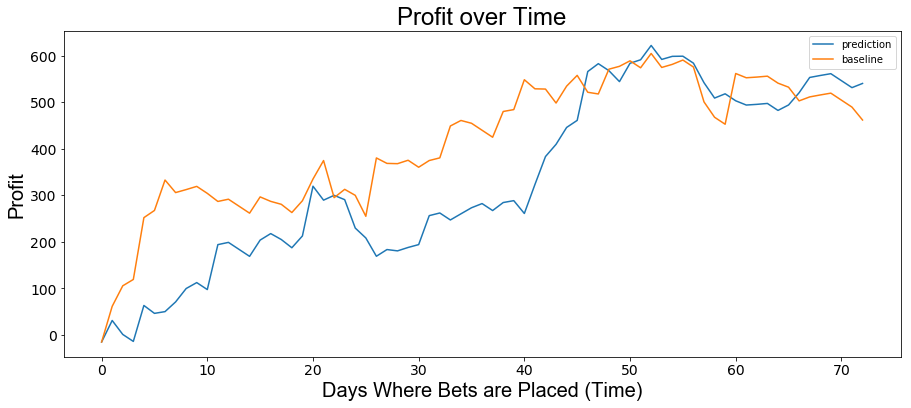

In [194]:
profitGraph(x)

In [195]:
getScoresFull(outcomeTable, X_train, y_train, X_test, y_test)

Logistic Accuracy Score: 0.55
Logistic Train Score: 0.54
Profit betting 15$: 111.54

Random Forest Accuracy Score: 0.61
Random Forest Train Score: 0.60
Profit betting 15$: 505.76


### ROC

In [196]:
fpr_ewm_diff, tpr_ewm_diff, roc_auc_ewm_diff = getMicroROC(X_train, y_train, X_test, y_test)

In [197]:
fpr_ewm_both, tpr_ewm_both, roc_auc_ewm_both = getMicroROC(X_train, y_train, X_test, y_test)

In [198]:
fpr_roll_diff, tpr_roll_diff, roc_auc_roll_diff = getMicroROC(X_train, y_train, X_test, y_test)

In [199]:
fpr_roll_both, tpr_roll_both, roc_auc_roll_both = getMicroROC(X_train, y_train, X_test, y_test)

In [200]:
fpr_expand_diff, tpr_expand_diff, roc_auc_expand_diff = getMicroROC(X_train, y_train, X_test, y_test)

In [201]:
fpr_expand_both, tpr_expand_both, roc_auc_expand_both = getMicroROC(X_train, y_train, X_test, y_test)

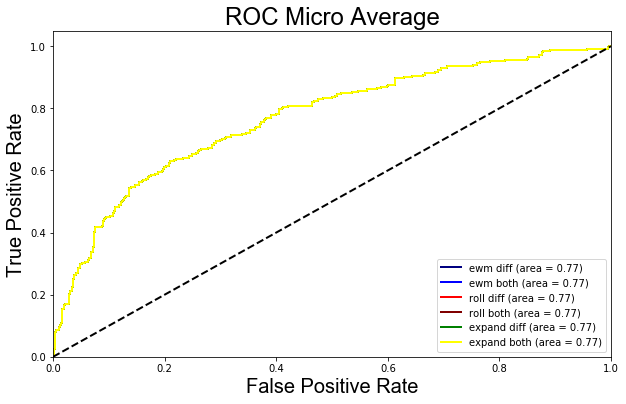

In [202]:
plt.figure(figsize = (10,6))
#ewm diff
plt.plot(fpr_ewm_diff["micro"], tpr_ewm_diff["micro"],
         label='ewm diff (area = {0:0.2f})'
               ''.format(roc_auc_ewm_diff["micro"]),
         color='navy', linestyle='-', linewidth=2)
#ewm both
plt.plot(fpr_ewm_both["micro"], tpr_ewm_both["micro"],
         label='ewm both (area = {0:0.2f})'
               ''.format(roc_auc_ewm_both["micro"]),
         color='blue', linestyle='-', linewidth=2)
#roll diff
plt.plot(fpr_roll_diff["micro"], tpr_roll_diff["micro"],
         label='roll diff (area = {0:0.2f})'
               ''.format(roc_auc_roll_diff["micro"]),
         color='red', linestyle='-', linewidth=2)
#roll both
plt.plot(fpr_roll_both["micro"], tpr_roll_both["micro"],
         label='roll both (area = {0:0.2f})'
               ''.format(roc_auc_roll_both["micro"]),
         color='maroon', linestyle='-', linewidth=2)
#expand diff
plt.plot(fpr_expand_diff["micro"], tpr_expand_diff["micro"],
         label='expand diff (area = {0:0.2f})'
               ''.format(roc_auc_expand_diff["micro"]),
         color='green', linestyle='-', linewidth=2)
#expand both
plt.plot(fpr_expand_both["micro"], tpr_expand_both["micro"],
         label='expand both (area = {0:0.2f})'
               ''.format(roc_auc_expand_both["micro"]),
         color='yellow', linestyle='-', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', **axis_font)
plt.ylabel('True Positive Rate', **axis_font)
plt.title('ROC Micro Average', **title_font)
plt.legend(loc="lower right")
plt.show()

### Using Unseen Data

In [231]:
preview = getPreviewStats(df1718)
past = rollingAverages(getPastStats(df1718), 5, 'ewm', 'diff')
total = pd.merge(preview, past, how='left', left_on=['homeTeam','awayTeam'], right_on = ['homeTeam','awayTeam'])
total = total.dropna()

In [232]:
X_test = total.drop(['homeTeam', 'awayTeam', 'date', 'outcome'], axis = 1).reset_index(drop=True)
X_test.awayOdds = pd.to_numeric(X_test.awayOdds)
X_test.drawOdds = pd.to_numeric(X_test.drawOdds)
X_test.homeOdds = pd.to_numeric(X_test.homeOdds)
y_test = total.outcome.reset_index(drop=True)
outcomeTable = total[['date','homeTeam', 'awayTeam', 'homeOdds', 'awayOdds',
                       'drawOdds', 'outcome']]

In [233]:
weights = [1.4 if x == 'Draw' else 1 for x in y_train]
rforest = RandomForestClassifier(50,max_depth =500, min_samples_leaf= 75, max_features = 0.3,
                                 min_samples_split = 200, random_state = 54)
rforest.fit(X_train, y_train, sample_weight=weights)
pred = rforest.predict(X_test)
y_score=rforest.predict_proba(X_test)

In [220]:
sX_train = scale(X_train)
sX_test = scale(X_test)
log = LogisticRegression(penalty='l1', C=0.1)
log.fit(sX_train, y_train, sample_weight=weights)
pred = log.predict(sX_test)

In [234]:
x = totalProfit(outcomeTable, 15, pred)
print(x.prediction.value_counts())
print(x.outcome.value_counts())
print(x.profit.sum())
print(x.baselineProfit.sum())

Home Win    108
Away Win     63
Draw         61
Name: prediction, dtype: int64
Home Win    103
Draw         65
Away Win     64
Name: outcome, dtype: int64
213.3608046207664
36.92573951356992


In [235]:
getScoresFull(outcomeTable, X_train, y_train, X_test, y_test)

Logistic Accuracy Score: 0.55
Logistic Train Score: 0.54
Profit betting 15$: 291.56

Random Forest Accuracy Score: 0.54
Random Forest Train Score: 0.60
Profit betting 15$: 113.01


In [236]:
(accuracy_score(x.outcome, x.baseline))

0.44396551724137934

## FiveThirtyEight

In [237]:
df538 = pd.read_csv('spi_matches.csv')
teamnames = {'AFC Bournemouth': 'Bournemouth', 'Brighton and Hove Albion': 'Brighton', 'Huddersfield Town': 'Huddersfield',
            'Leicester City': 'Leicester', 'Manchester City': 'Man City', 'Manchester United': 'Man Utd',
            'Stoke City': 'Stoke', 'Swansea City': 'Swansea', 'Tottenham Hotspur': 'Tottenham',
            'West Bromwich Albion': 'West Brom', 'West Ham United': 'West Ham'}
df538.team1.replace(teamnames, inplace = True);
df538.team2.replace(teamnames, inplace = True);

In [238]:
totalwith538 = pd.merge(x, df538[['team1', 'team2', 'pred538']]
                        , how='left', left_on=['homeTeam','awayTeam'], right_on = ['team1','team2'])

In [239]:
totalwith538.drop(['team1', 'team2'], axis = 1, inplace = True)

In [240]:
totalwith538['profit538'] = totalwith538.apply(lambda row:
                                          profit(15, row['outcomeOdds']) if row['outcome'] == row['pred538']
                                          else 0 if row['prediction'] == 'None' else -15, axis = 1)

In [241]:
totalwith538.profit538.sum()

-379.1411297778879

In [247]:
(accuracy_score(totalwith538.dropna().outcome, totalwith538.dropna().pred538))

0.5286343612334802

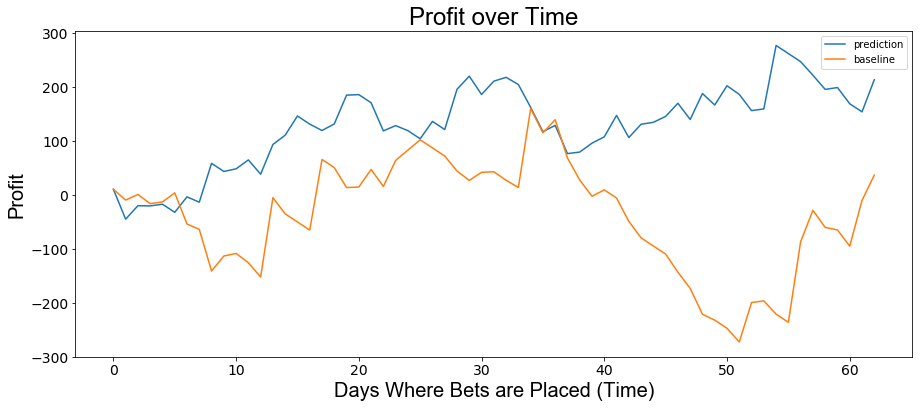

In [248]:
profitGraph(x)

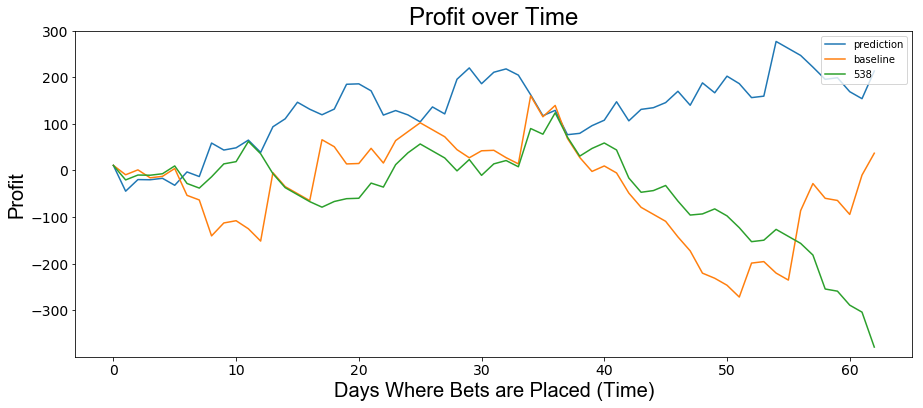

In [258]:
bankroll = 0
bankrollbydate = []
baseline = 0
baselinebydate = []
bankroll538 = 0
bankroll538bydate = []
dates = []
profitbydate = totalwith538.groupby('date', as_index=False)[['profit', 'baselineProfit', 'profit538']].sum()
for i in range(len(profitbydate)):
    bankroll = bankroll + profitbydate.iloc[i,1]
    dates.append(profitbydate.iloc[i,0])
    bankrollbydate.append(bankroll)
    baseline = baseline + profitbydate.iloc[i,2]
    baselinebydate.append(baseline)
    bankroll538 = bankroll538 + profitbydate.iloc[i,3]
    bankroll538bydate.append(bankroll538)

plt.figure(figsize=(15,6));
plt.plot(range(len(dates)),bankrollbydate,  label = 'prediction')
plt.plot(range(len(dates)),baselinebydate, label = 'baseline')
plt.plot(range(len(dates)),bankroll538bydate, label = '538')
plt.xlabel('Days Where Bets are Placed (Time)', **axis_font)
plt.ylabel('Profit', **axis_font)
plt.title('Profit over Time', **title_font)
plt.xticks(fontsize=14)
plt.yticks(range(-300,600,100),fontsize=14)
plt.ylim(-400,300)
plt.legend(fontsize = 'medium', fancybox = True, loc = 'upper right')
plt.show();

In [216]:
(accuracy_score(x.outcome, x.baseline))

0.44396551724137934

### Feature Importance and Graphing

In [ ]:
cols[17]

In [ ]:
indices[:10]

In [ ]:
importances = rforest.feature_importances_
std = np.std([tree.feature_importances_ for tree in rforest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1][:7]

cols = X_test.columns.tolist()
importcols = []
for i in indices:
    importcols.append(cols[i])
# Print the feature ranking
print("Feature ranking:")

for f in range(7):
    print("%d. %s (%f)" % (f + 1, cols[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(15,6))
#plt.title("Feature Importance", **title_font)
plt.bar(range(7), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(7), importcols, fontsize=14, rotation=50)
plt.yticks(**axis_font)
plt.xlim([-1, 7])
plt.show()

### CONFUSION MATRIX

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, **title_font)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', **axis_font)
    plt.xlabel('Predicted label', **axis_font)

In [ ]:
# Data to plot
labels = 'Home Win', 'Away Win', 'Draw'
outcomes = df.outcome.value_counts()
sizes = [outcomes[0], outcomes[1],outcomes[2]]
colors = ['yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0)  # explode 1st slice
 
# Plot
plt.figure(figsize=(10,6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90)
 
plt.axis('equal', **axis_font)
plt.title('Percentage of Outcomes in the English Premier League', **title_font)
plt.show()

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,6))
plot_confusion_matrix(cnf_matrix, classes=['Away Win', 'Draw', 'Home Win'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,6))
plot_confusion_matrix(cnf_matrix, classes=['Away Win', 'Draw', 'Home Win'], normalize=True,
                      title='Confusion Matrix')

plt.show()

### GRID SEARCH

In [ ]:
tscv = TimeSeriesSplit(n_splits=3)

In [ ]:
###my_scorer = make_scorer(totalProfit, greater_is_better=True)

### Logistic Regression

In [ ]:
np.logspace(-4,3,8)

In [ ]:
parameters = {'C': np.logspace(-4, 3, 8)}

log = LogisticRegression(n_jobs = -1, penalty="l1")
grid = GridSearchCV(estimator = log, param_grid = parameters, cv = tscv)
grid.fit(sX_train,y_train)

#different metrics you can call
grid.score(sX_test, y_test)

grid.grid_scores_

grid.best_estimator_

### KNN Classifier

In [ ]:
parameters = {'n_neighbors': np.arange(1, 65, 1)}

knn = KNeighborsClassifier(n_jobs = -1)
grid = GridSearchCV(estimator = knn, param_grid = parameters, cv = tscv)
grid.fit(sX_train,y_train)

#different metrics you can call
grid.score(sX_test, y_test)

grid.grid_scores_

grid.best_estimator_

### SVC Classifier

In [ ]:
parameters = {'C': np.logspace(-4, 3, 8)}

svc = SVC()
grid = GridSearchCV(estimator = svc, param_grid = parameters, cv = tscv)
grid.fit(sX_train,y_train)

#different metrics you can call
grid.score(sX_test, y_test)

grid.grid_scores_

grid.best_estimator_

### Random Forest Classifier

In [ ]:
parameters = {'n_estimators': np.arange(20,35) ,'min_samples_split': np.arange(10,100,10), 
              'min_samples_leaf': np.arange(6,11,1), 'max_features': np.arange(0.3,0.52,0.02),
              'max_depth': np.arange(40,120,20)}

rfc = RandomForestClassifier(n_jobs = -1)
grid = GridSearchCV(estimator = rfc, param_grid = parameters, cv = tscv)
grid.fit(X_train,y_train)

#different metrics you can call
grid.score(X_test, y_test)

grid.grid_scores_

print(grid.best_estimator_)

### END - Nice to Haves Under

In [ ]:
#oddsTable.groupby('date').profit.sum()

In [ ]:
def pctOdds(odds):
    odds = pd.to_numeric(odds)
    if odds < 0:
        pctOdds = -(odds)/(-(odds)+100)
    else:
        pctOdds = 100/(odds+100)
    return pctOdds

In [ ]:
confPred = []
for i in range(len(y_score)):
    homeOdds = pctOdds(outcomeTable.iloc[i,3]) #home implied odds
    awayOdds = pctOdds(outcomeTable.iloc[i,4]) #away implied odds
    drawOdds = pctOdds(outcomeTable.iloc[i,5]) #draw implied odds
    calcHome = y_score[i][2]
    calcAway = y_score[i][0]
    calcDraw = y_score[i][1]
    #print(outcomeTable.iloc[i,1], outcomeTable.iloc[i,2]);
    #print("Home %s, Away %s, Draw %s" % (homeOdds,awayOdds, drawOdds));
    #print("Home %s, Away %s, Draw %s" % (calcHome, calcAway, calcDraw));
    #print("Prediction %s, Outcome %s" %(outcomeTable.iloc[i,7], outcomeTable.iloc[i,6]));

In [ ]:
decision_tree = rforest.estimators_[3]
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# decision tree viz
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz 

dot_data = StringIO()

export_graphviz(decision_tree.fit(X_train, y_train), 
				out_file = dot_data,
                feature_names=X_test.columns.tolist(),  
                filled=True, rounded=True, 
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())